# Initial look at the dataset

Data consists of 11 columns that hold information about 303 patients diagnosed with heart diseases in V.A. Medical Center in Long Beach, CA. The columns are:

1. age - patient's age
2. sex - patient's sex (likely 1 = male, 0 = female; not important for the task)
3. cp - chest pain type (1-4, meaning unclear)
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)
5. chol - serum cholesterol in mg/dl
6. fbs - fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
7. restecg - resting electrocardiographic results (0-2, meaning unclear)
8. thalach - maximum heart rate achieved in bpm
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest in mV
11. slope - the slope of the peak exercise ST segment (possibly 1 = upsloping, 2 = downsloping, 3 = horizontal)

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('heart_disease_patients.csv')
df.head()

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,1,63,1,1,145,233,1,2,150,0,2.3,3
1,2,67,1,4,160,286,0,2,108,1,1.5,2
2,3,67,1,4,120,229,0,2,129,1,2.6,2
3,4,37,1,3,130,250,0,0,187,0,3.5,3
4,5,41,0,2,130,204,0,2,172,0,1.4,1


In [3]:
df = df.drop('id', axis=1)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,63,1,1,145,233,1,2,150,0,2.3,3
1,67,1,4,160,286,0,2,108,1,1.5,2
2,67,1,4,120,229,0,2,129,1,2.6,2
3,37,1,3,130,250,0,0,187,0,3.5,3
4,41,0,2,130,204,0,2,172,0,1.4,1


In [4]:
from sklearn.model_selection import train_test_split
train_tmp, test = train_test_split(df, test_size = 0.2)
train, valid = train_test_split(train_tmp, test_size = 0.2)

In [5]:
print(len(train))

193


In [6]:
print(train.isnull().values.any())

False


# Preprocessing

We drop the id column as it should not influence the clustering.

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193 entries, 251 to 199
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       193 non-null    int64  
 1   sex       193 non-null    int64  
 2   cp        193 non-null    int64  
 3   trestbps  193 non-null    int64  
 4   chol      193 non-null    int64  
 5   fbs       193 non-null    int64  
 6   restecg   193 non-null    int64  
 7   thalach   193 non-null    int64  
 8   exang     193 non-null    int64  
 9   oldpeak   193 non-null    float64
 10  slope     193 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 18.1 KB


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'cp'}>],
       [<AxesSubplot:title={'center':'trestbps'}>,
        <AxesSubplot:title={'center':'chol'}>,
        <AxesSubplot:title={'center':'fbs'}>],
       [<AxesSubplot:title={'center':'restecg'}>,
        <AxesSubplot:title={'center':'thalach'}>,
        <AxesSubplot:title={'center':'exang'}>],
       [<AxesSubplot:title={'center':'oldpeak'}>,
        <AxesSubplot:title={'center':'slope'}>, <AxesSubplot:>]],
      dtype=object)

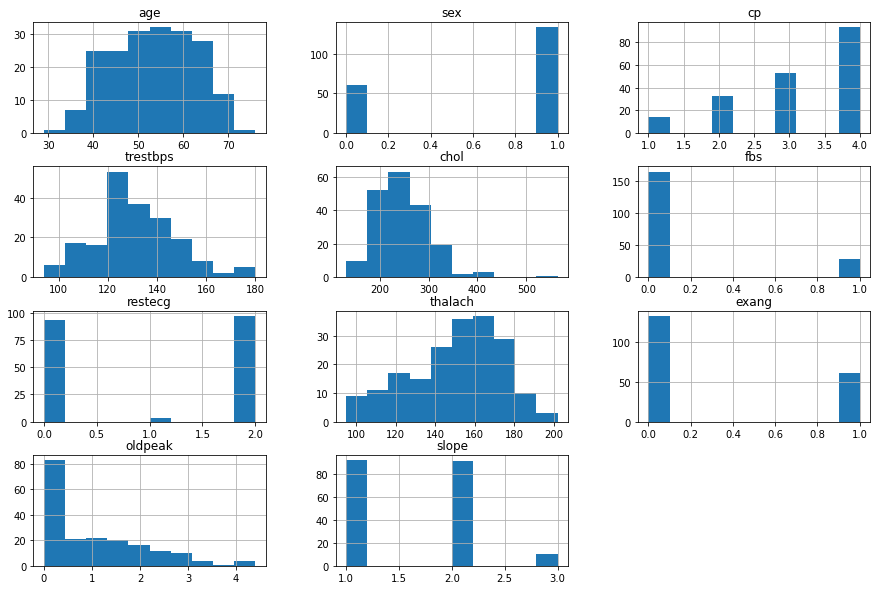

In [8]:
train.hist(figsize = (15, 10))

As you can see, the dataset contains both numerical values and categorical values. Many standard clustering algorithms can only be used for one of them. We will try different approaches to deal with this problem.

In [9]:
train[train['exang'] < 0]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope


In [14]:
scaler = StandardScaler()
scaler.fit(train)

StandardScaler()

# KMeans algorithm

## Encoding cp, restecg, slope variables

cp, restecg and slope variables are categorical and distance does not make sense in terms of them, so let's use one hot encoding to solve this problem.

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193 entries, 251 to 199
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       193 non-null    int64  
 1   sex       193 non-null    int64  
 2   cp        193 non-null    int64  
 3   trestbps  193 non-null    int64  
 4   chol      193 non-null    int64  
 5   fbs       193 non-null    int64  
 6   restecg   193 non-null    int64  
 7   thalach   193 non-null    int64  
 8   exang     193 non-null    int64  
 9   oldpeak   193 non-null    float64
 10  slope     193 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 18.1 KB


## Finding the optimal number of clusters

In [16]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [17]:
n_clusters_range = range(2,15)

In [18]:
def calc_kmeans_inertia(n_clusters): 
    model = KMeans(n_clusters=n_clusters, n_init=1)
    pipeline = Pipeline([
    ('transform', scaler),
    ('fit', model)])
    pipeline.fit(train)
    
    return model.inertia_

In [19]:
def get_kmeans_inertias():
    inertias = []
    for i in n_clusters_range:
        inertias.append(calc_kmeans_inertia(i))
    return inertias

In [20]:
import matplotlib.pyplot as plt

def show_inertias(inertias):
    plt.plot(n_clusters_range, inertias, marker='o')
    plt.xticks(n_clusters_range)
    plt.title('Number of clusters vs inertia')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

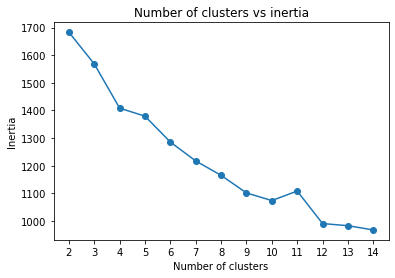

In [53]:
inertias = get_kmeans_inertias()
show_inertias(inertias)

Na podstawie analizy wykresu można wysnuć wniosek, że 6 klastrów wydaje się być wartością optymalną.

In [54]:
clusters_count_kmeans = 5

## Model training and results visualization

In [55]:
best_kmeans_model = KMeans(n_clusters=clusters_count_kmeans, n_init=1).fit(train)

def get_best_kmeans_labels(dataset):
    pred = best_kmeans_model.predict(dataset)
    return pred

In [56]:
get_best_kmeans_labels(train)

array([4, 1, 0, 3, 0, 1, 3, 0, 1, 0, 0, 4, 1, 0, 0, 3, 3, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 4, 0, 4, 0, 4, 3, 4, 3, 4, 0, 2, 1, 0, 0, 1, 1, 0, 1,
       1, 3, 4, 4, 4, 0, 1, 0, 4, 0, 3, 0, 3, 3, 0, 1, 1, 3, 0, 1, 3, 1,
       4, 1, 0, 0, 3, 2, 0, 3, 0, 3, 1, 1, 1, 1, 1, 0, 3, 3, 1, 1, 0, 3,
       3, 4, 0, 3, 1, 3, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 4, 1, 4, 1, 1,
       1, 3, 4, 0, 2, 1, 1, 0, 0, 4, 3, 0, 1, 0, 0, 0, 4, 1, 3, 1, 3, 0,
       3, 1, 3, 0, 1, 4, 3, 3, 3, 1, 1, 3, 1, 0, 3, 0, 4, 0, 0, 1, 0, 3,
       0, 3, 1, 0, 3, 0, 4, 0, 4, 4, 4, 1, 3, 3, 3, 0, 0, 4, 0, 4, 4, 1,
       4, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 4, 1])

Po wykonaniu klasteryzacji spłaszczamy dane do mniejszej ilości wymiarów w celu zwizualizowania podziału obserwacji na klastry.

In [57]:
from sklearn.decomposition import PCA
import numpy as np

[0.27032686 0.12167134 0.11162497 0.09723177 0.08383659 0.07316379
 0.06942443 0.06334829 0.04595735 0.03310454 0.03031008]


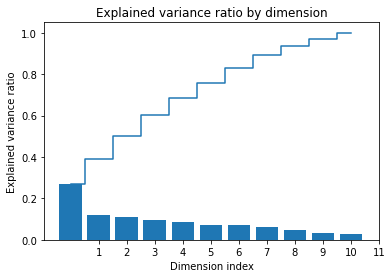

In [58]:
pca = PCA()
pipeline = Pipeline([
    ('transform', scaler),
    ('fit', pca) 
    ])
pipeline.fit(train)

explained_variance = pca.explained_variance_ratio_

plt.bar(np.arange(len(explained_variance)), explained_variance)
plt.title('Explained variance ratio by dimension')
plt.xlabel('Dimension index')
plt.ylabel('Explained variance ratio')

cum_sum_eigenvalues = np.cumsum(explained_variance)
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')

xticks = range(1, len(pca.components_) + 1)
plt.xticks(xticks)

print(explained_variance)

All of the dimensions contribute significantly to variance explanation, so it is hard to visualize the clusters on a plot (with max 3 dimensions).

In [59]:
pca_reduced = PCA(n_components=3)
pca_reduced.fit(train)

def show_3d_clustering(dataset, method):
    '''
    available methods: ['kmeans', 'gower', 'agglomerative', 'kmeds']
    '''
    if method == "kmeans":
        pred = get_best_kmeans_labels(dataset)
    elif method == "gower":
        pred = get_best_gower_labels(dataset)
    elif method == "agglomerative":
        pred = get_best_agglomerative_labels(dataset)
    elif method == "kmeds":
        pred = get_best_kmeds_labels(dataset)
    else:
        print("available methods: ['kmeans', 'gower', 'agglomerative', 'kmeds']")
        return
    
    low_d = pca_reduced.transform(dataset)

    for class_ in range(0, clusters_count_kmeans + 1):
        class_members = np.where(pred == class_)
        class_points = low_d[class_members]
        xs = [point[0] for point in class_points]
        ys = [point[1] for point in class_points]
        zs = [point[2] for point in class_points]

        plt.scatter(xs, ys, zs, alpha=0.5)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


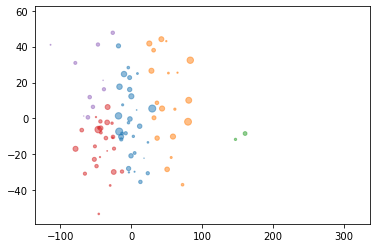

In [60]:
show_3d_clustering(train, 'kmeans')

## Interpreting clusters

In [61]:
def get_dataset_with_clusters(dataset, method):
    '''
    available methods: ['kmeans', 'gower', 'agglomerative', 'kmeds']
    '''
    if method == "kmeans":
        pred = get_best_kmeans_labels(dataset)
    elif method == "gower":
        pred = get_best_gower_labels(dataset)
    elif method == "agglomerative":
        pred = get_best_agglomerative_labels(dataset)
    elif method == "kmeds":
        pred = get_best_kmeds_labels(dataset)
    else:
        print("available methods: ['kmeans', 'gower', 'agglomerative', 'kmeds']")
        return
    dataset_clustered = dataset.copy()
    dataset_clustered['cluster'] = pred
    return dataset_clustered

In [62]:
get_dataset_with_clusters(train, "kmeans")

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,cluster
251,58,1,4,146,218,0,0,105,0,2.0,2,4
291,55,0,2,132,342,0,0,166,0,1.2,1,1
281,47,1,3,130,253,0,0,179,0,0.0,1,0
117,35,0,4,138,183,0,0,182,0,1.4,1,3
144,58,1,3,105,240,0,2,154,1,0.6,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
266,52,1,4,128,204,1,0,156,1,1.0,2,3
222,39,0,3,94,199,0,0,179,0,0.0,1,3
239,42,1,2,120,295,0,0,162,0,0.0,1,1
226,47,1,4,112,204,0,0,143,0,0.1,1,4


In [63]:
from collections import defaultdict

def show_stats_by_cluster(dataset, method):
    '''
    available methods: ['kmeans', 'gower', 'agglomerative', 'kmeds']
    '''
    dataset_clustered = get_dataset_with_clusters(dataset, method)
    plt.rcParams['errorbar.capsize'] = 5
    stats = defaultdict(dict)

    numeric_stats = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    bool_stats = ['fbs', 'exang']
    categorical_stats = ['cp', 'restecg', 'slope']

    for cluster, new_df in dataset_clustered.groupby('cluster'):
        cluster_description = new_df.describe().loc[['mean', 'min', 'max']]

        for col_name, col_data in cluster_description.items():
            if col_name in numeric_stats + bool_stats:
                stats[col_name][cluster] = col_data

    colors = ['#1b9e77', '#a9f971', '#fdaa48','#6890F0','#A890F0', 'pink']

    for stat_name, stat in stats.items(): 
        unzipped = list(zip(*stat.values()))
        plt.figure()

        if stat_name in bool_stats:
            stat = stats[stat_name]
            plt.bar(stat.keys(), unzipped[0], color=colors)
            plt.title(f'Percentage of true values: {stat_name}')
            plt.xlabel('Cluster index')

            continue

        means = unzipped[0]
        min_ = np.array(unzipped[1])
        min_ = means - min_
        max_ = np.array(unzipped[2])
        max_ = max_ - means

        yerr = np.dstack((min_, max_))[0]
        yerr = np.transpose(yerr)

        plt.bar(stat.keys(), means, yerr=yerr, color=colors)
        plt.title(stat_name)
        plt.xlabel('Cluster index')
        plt.ylabel('Value')

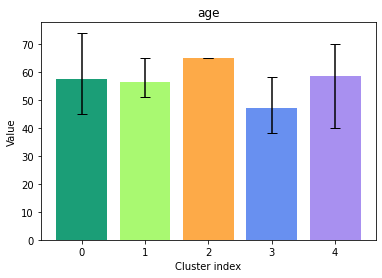

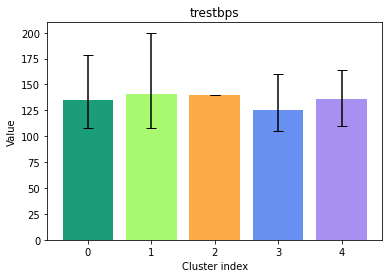

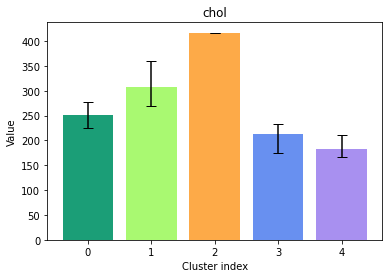

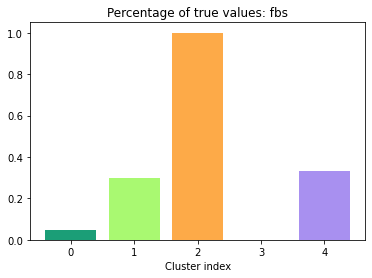

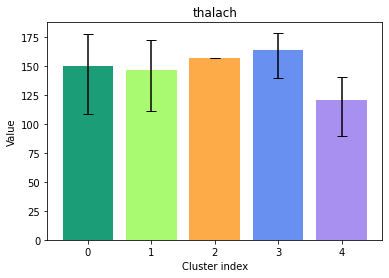

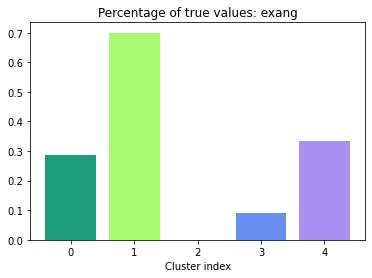

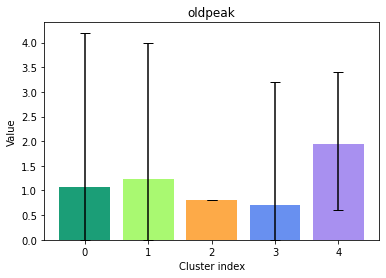

In [64]:
show_stats_by_cluster(valid, 'kmeans')

In [92]:
categorical_stats = ['cp', 'restecg', 'slope']
def show_most_common(dataset, method):
    '''
    available methods: ['kmeans', 'gower', 'agglomerative', 'kmeds']
    '''
    for stat in categorical_stats:

        dataset_clustered = get_dataset_with_clusters(dataset, method)
        dfg = dataset_clustered.groupby(['cluster',stat])
        frequencies = dfg.size().unstack()
        frequencies = frequencies.fillna(0)
        most_common = frequencies.idxmax(axis=1)
        summary = pd.DataFrame(most_common, columns=['Most common value'])
        print(f'Most common values of {stat}')
        display(summary.style)

In [93]:
show_most_common(train, 'kmeans')

Most common values of cp


,Most common value
cluster,
0,4
1,4
2,4
3,3
4,4


Most common values of restecg


,Most common value
cluster,
0,2
1,2
2,2
3,0
4,0


Most common values of slope


,Most common value
cluster,
0,2
1,2
2,2
3,1
4,2


# Aglomerative Clustering with Gower Matrix

In [94]:
import gower
from sklearn_extra.cluster import KMedoids
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
dist_matrix = gower.gower_matrix(train)

In [95]:
def calc_gower_silhouette(n_clusters):
    model1 = AgglomerativeClustering(n_clusters=n_clusters, 
                                affinity='precomputed', linkage = 'single').fit(dist_matrix)
    model2 = AgglomerativeClustering(n_clusters=n_clusters, 
                                affinity='precomputed', linkage = 'average').fit(dist_matrix)
    model3 = AgglomerativeClustering(n_clusters=n_clusters, 
                                affinity='precomputed', linkage = 'complete').fit(dist_matrix)
    
    return np.array([silhouette_score(dist_matrix, model1.labels_),
                     silhouette_score(dist_matrix, model2.labels_),
                     silhouette_score(dist_matrix, model3.labels_)])

In [96]:
def get_gower_silhouettes():
    silhouettes = np.empty((13,3))
    for i in n_clusters_range:
        silhouettes[i-2] = calc_gower_silhouette(i)
    return silhouettes

In [97]:
def show_silhouettes(silhouettes):
    for i in range(silhouettes.shape[1]):
        plt.plot(n_clusters_range, silhouettes[:,i], marker='o')
    labels = ["single", "average", "complete"]
    if silhouettes.shape[1] ==4:
        labels.append("ward")
    plt.xticks(n_clusters_range)
    plt.title('Number of clusters vs Silhouette')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette')
    if silhouettes.shape[1]>1:
        plt.legend(labels)
    plt.show()

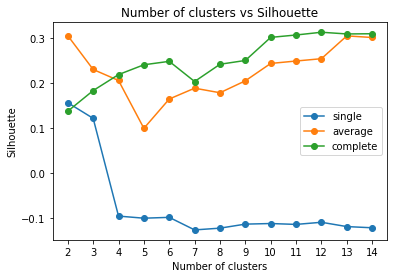

In [98]:
silhouettes = get_gower_silhouettes()
show_silhouettes(silhouettes)

In [99]:
clusters_count_gower = 9

In [100]:
def get_best_gower_labels(dataset):
    dist_matrix = gower.gower_matrix(dataset)
    model = AgglomerativeClustering(n_clusters=clusters_count_gower, 
                                affinity='precomputed', linkage = 'complete').fit(dist_matrix)
    pred = model.labels_
    return pred

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


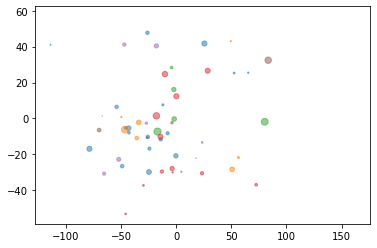

In [101]:
show_3d_clustering(train, "gower")

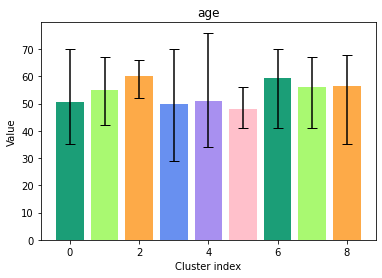

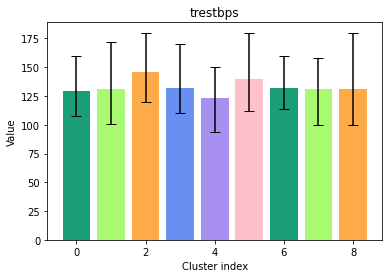

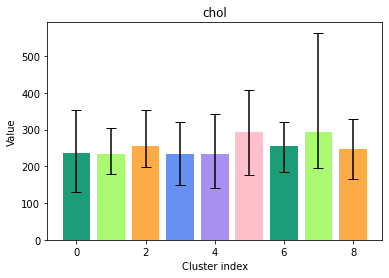

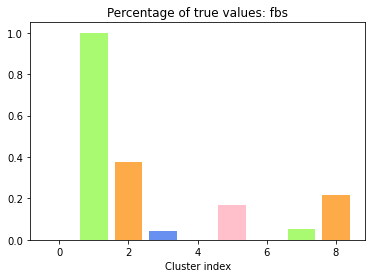

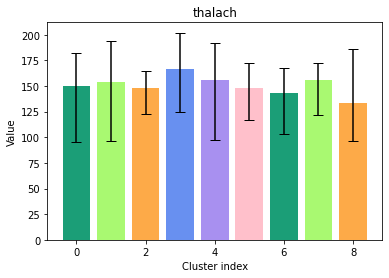

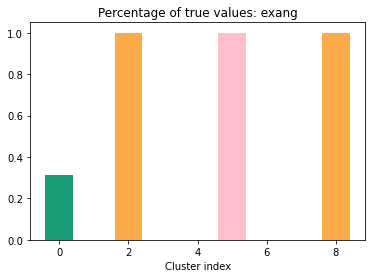

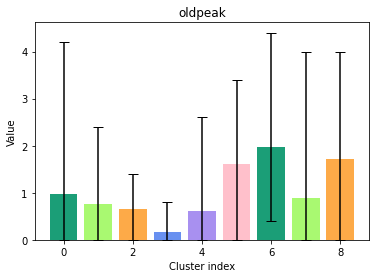

In [102]:
show_stats_by_cluster(train, 'gower')

In [103]:
show_most_common(train, 'gower')

Most common values of cp


,Most common value
cluster,
0,4
1,3
2,4
3,4
4,3
5,4
6,4
7,4
8,4


Most common values of restecg


,Most common value
cluster,
0,0
1,0
2,0
3,2
4,0
5,2
6,2
7,2
8,2


Most common values of slope


,Most common value
cluster,
0,1
1,1
2,2
3,1
4,1
5,2
6,2
7,1
8,2


In [104]:
def calc_agglomerative_silhouette(n_clusters):
    scaler = StandardScaler()
    model1 = AgglomerativeClustering(n_clusters=n_clusters, linkage = 'single')
    model2 = AgglomerativeClustering(n_clusters=n_clusters, linkage = 'average')
    model3 = AgglomerativeClustering(n_clusters=n_clusters, linkage = 'complete')
    model4 = AgglomerativeClustering(n_clusters=n_clusters, linkage = 'ward')
    pipeline1 = Pipeline([('transform', scaler), ('fit', model1)])
    pipeline2 = Pipeline([('transform', scaler), ('fit', model2)])
    pipeline3 = Pipeline([('transform', scaler), ('fit', model3)])
    pipeline4 = Pipeline([('transform', scaler), ('fit', model4)])
    y1 = pipeline1.fit_predict(train)
    y2 = pipeline2.fit_predict(train)
    y3 = pipeline3.fit_predict(train)
    y4 = pipeline4.fit_predict(train)
    return np.array([silhouette_score(train, y1),
silhouette_score(train, y2),
silhouette_score(train, y3),
silhouette_score(train, y4)])

In [107]:
def get_agglomerative_silhouettes():
    silhouettes = np.empty((13,4))
    for i in n_clusters_range:
        silhouettes[i-2] = calc_agglomerative_silhouette(i)
    return silhouettes

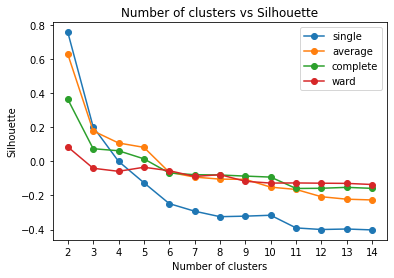

In [108]:
silhouettes = get_agglomerative_silhouettes()
show_silhouettes(silhouettes)

In [109]:
clusters_count_agglomerative = 5
def get_best_agglomerative_labels(dataset):
    
    model = AgglomerativeClustering(n_clusters=clusters_count_agglomerative, linkage = 'ward')
    pipeline = Pipeline([
    ('transform', scaler),
    ('fit', model) 
    ])
    pipeline.fit(dataset)
    pred = model.labels_
    return pred

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


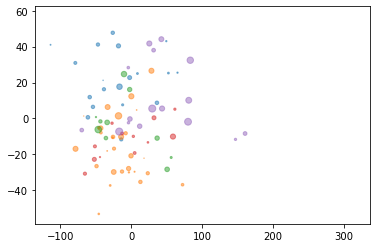

In [110]:
show_3d_clustering(train, 'agglomerative')

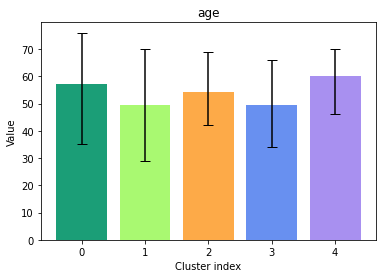

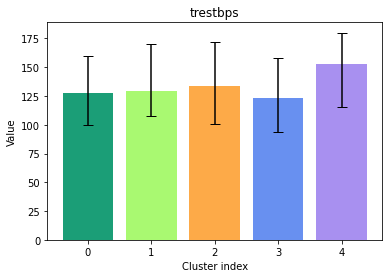

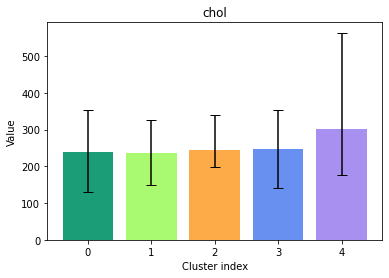

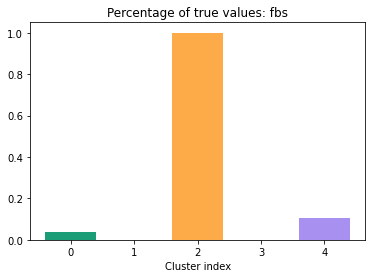

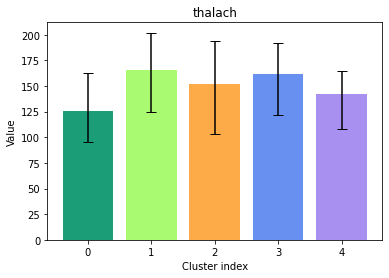

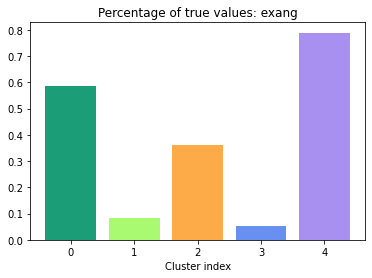

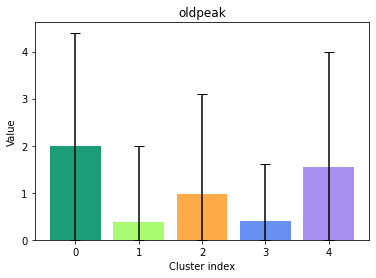

In [111]:
show_stats_by_cluster(train, 'agglomerative')

In [112]:
show_most_common(train, 'agglomerative')

Most common values of cp


,Most common value
cluster,
0,4
1,2
2,3
3,3
4,4


Most common values of restecg


,Most common value
cluster,
0,2
1,2
2,2
3,0
4,2


Most common values of slope


,Most common value
cluster,
0,2
1,1
2,1
3,1
4,2


In [113]:
def calc_kmed_inertia(n_clusters):
    model = KMedoids(n_clusters=n_clusters,
                           method='pam', init='build', 
                           max_iter=300)
    pipeline = Pipeline([
    ('transform', scaler),
    ('fit', model) 
    ])
    pipeline.fit(train)
    model.predict(train)
    return model.inertia_

In [114]:
def get_kmed_inertias():
    inertias = []
    for i in n_clusters_range:
        inertias.append(calc_kmed_inertia(i))
    return inertias

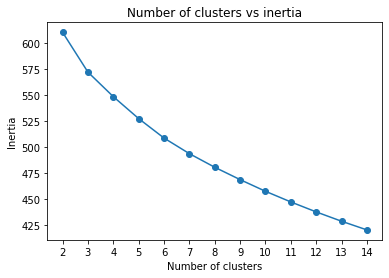

In [115]:
inertias = get_kmed_inertias()
show_inertias(inertias)

In [116]:
def calc_kmed_silhouette(n_clusters):
    model = KMedoids(n_clusters=n_clusters,
                           method='pam', init='build', 
                           max_iter=300)
    pipeline = Pipeline([('transform', scaler), ('fit', model)])
    pipeline.fit(train)
    y = model.predict(train)
    return silhouette_score(train, model.labels_) # labels not predictions because its terrible at predictions

In [117]:
def get_kmed_silhouettes():
    silhouettes = np.empty((13,1))
    for i in n_clusters_range:
        silhouettes[i-2] = calc_kmed_silhouette(i)
    return silhouettes

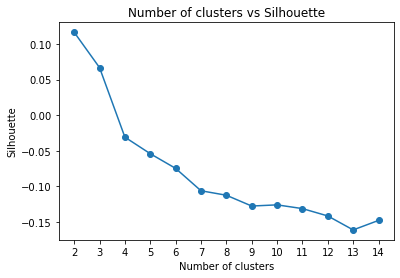

In [118]:
silhouettes = get_kmed_silhouettes()
show_silhouettes(silhouettes)

In [119]:
cluster_count_kmed = 3

In [120]:
def get_best_kmeds_labels(dataset):
    model = KMedoids(n_clusters=cluster_count_kmed,
                           method='pam', init='build', 
                           max_iter=300)
    pipeline = Pipeline([
    ('transform', scaler),
    ('fit', model) 
    ])
    pipeline.fit(dataset)
    pred = model.labels_
    return pred

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


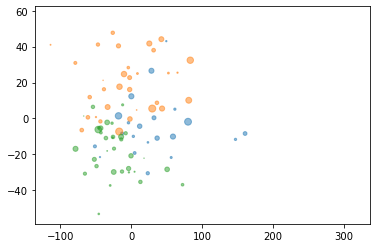

In [121]:
show_3d_clustering(train, 'kmeds')

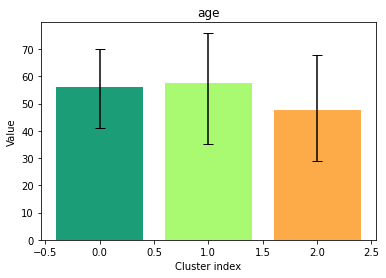

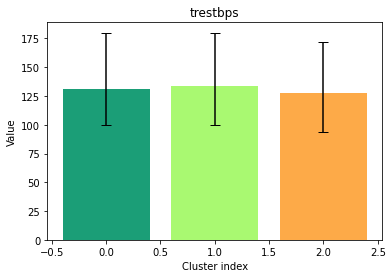

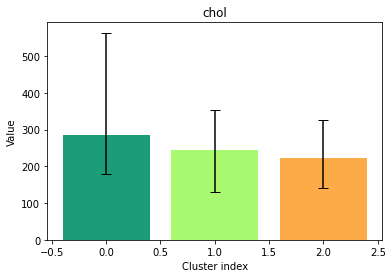

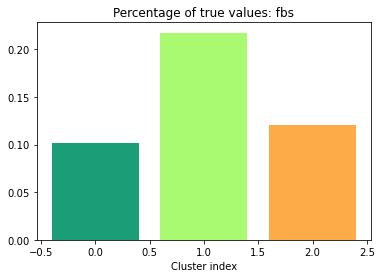

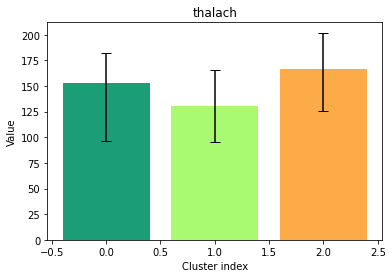

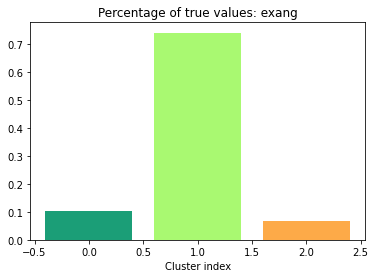

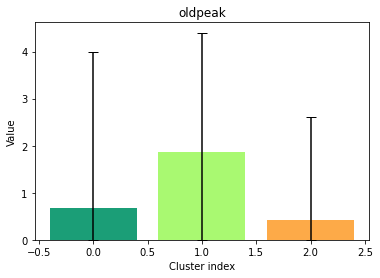

In [122]:
show_stats_by_cluster(train, "kmeds")

In [123]:
show_most_common(train, "kmeds")

Most common values of cp


,Most common value
cluster,
0,4
1,4
2,3


Most common values of restecg


,Most common value
cluster,
0,2
1,2
2,0


Most common values of slope


,Most common value
cluster,
0,1
1,2
2,1
